Python ile Bayesci Çıkarım (Bayesian Inference)
===============================================

## İkili Sonuçlara Sahip İki Grubun Karşılaştırılması

<p>İkili sonuçlar, klinik araştırmalarda sıkça karşımıza çıkar: </p>

* Sağkalım/Ölüm
* Doğru/Yanlış
* Varlık/Yokluk
* Pozitif/Negatif

<p>Uygulamada, ikili sonuçlar birler (gerçekleşen durumlar için) ve sıfırlar (gerçekleşmeyen durumlar için) ile kodlanır. Tek bir ikili değişken *Bernoulli* rasgele değişkeni olarak dağılır:</p>

<img src="src/ber_dist.svg">

<p>Bu tür olaylar bazen, bağımsız olayların toplamları ile açıklanır. Bernoulli olaylarının toplamları, *Binom* rasgele değişkenleri olarak dağılır:</p>

<img src="src/bin_dist.svg">

<p>Her iki dağılımda da $p $ parametresi, olayın gerçekleşme olasılığını belirler. Çıkarım açısından, bir gruptaki $p $ değerinin diğer grubunkine göre büyük ya da küçük olmasıyla ilgileniriz.</p>

<p>Örnek için kullanacağımız veriseti, Duke Üniversitesi Sağlık Merkez'inde 1981-87 yılları arasında 1600 gramdan daha az doğum ağırlığına sahip 671 bebeğe ait verileri içeriyor. İntraventriküler kanama (IVH) ve doğum ağırlığı, gebelik yaşı, pnömotoraks varlığı ve doğum şekli gibi değişkenler arasındaki ilişki ile ilgileniyoruz.</p>

In [1]:
import pandas as pd

vlbw = pd.read_csv('data/vlbw.csv', index_col=0).dropna(axis=0, subset=['ivh', 'pneumo'])
vlbw.head()

,birth,exit,hospstay,lowph,pltct,race,bwt,gest,inout,twn,...,vent,pneumo,pda,cld,pvh,ivh,ipe,year,sex,dead
5,81.593002,81.598999,2.0,6.969997,54.0,black,925.0,28.0,born at Duke,0.0,...,1.0,1.0,0.0,0.0,definite,definite,NaN,81.594055,female,1
6,81.601997,81.771004,62.0,7.189999,NaN,white,940.0,28.0,born at Duke,0.0,...,1.0,0.0,0.0,0.0,absent,absent,absent,81.602295,female,0
13,81.683998,81.853996,62.0,7.179996,182.0,black,1110.0,28.0,born at Duke,0.0,...,0.0,1.0,0.0,1.0,absent,absent,absent,81.684448,male,0
14,81.689003,81.877998,69.0,7.419998,361.0,white,1180.0,28.0,born at Duke,0.0,...,0.0,0.0,0.0,0.0,absent,absent,absent,81.689880,male,0
16,81.696999,81.952004,93.0,7.239998,255.0,black,770.0,26.0,born at Duke,0.0,...,1.0,0.0,0.0,1.0,absent,absent,absent,81.698120,male,0


<p>İkili veri analizini anlatmak için, pnömotoraks varlığı ile intraventriküler kanama arasındaki ilişkiyi inceleyeceğiz.</p>

In [2]:
pd.crosstab(vlbw.ivh, vlbw.pneumo)

pneumo,0.0,1.0
ivh,,
absent,359,73
definite,45,30
possible,6,4


<p>İkili sonuç oluşturmak için, *definite* ve *possible* çıktılarını bir değişkende birleştireceğiz.</p>

In [3]:
ivh = vlbw.ivh.isin(['definite', 'possible']).astype(int).values
x = vlbw.pneumo.astype(int).values

## Önsel Seçim

<p>$p $ parametresi sıfır ile bir arasında değerler aldığından, önsel dağılım olarak *beta* dağılımını seçeceğiz:</p>

<img src="src/beta_dist.svg">

1. Destek: <img src="src/beta_sup.svg">
2. Ortalama: <img src="src/beta_mean.svg">
3. Varyans: <img src="src/beta_var.svg">

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

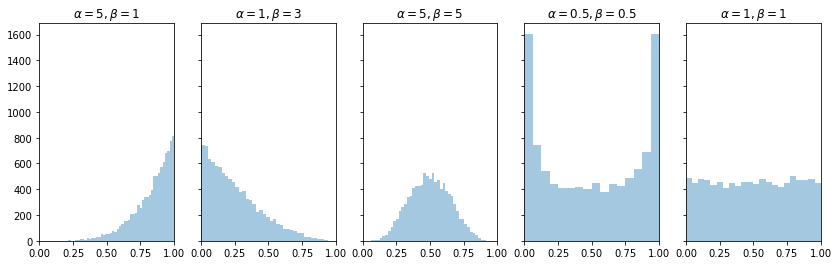

In [5]:
from pymc3 import Beta

params = (5, 1), (1, 3), (5, 5), (0.5, 0.5), (1, 1)

fig, axes = plt.subplots(1, len(params), figsize=(14, 4), sharey=True)
for ax, (alpha, beta) in zip(axes, params):
    sns.distplot(Beta.dist(alpha, beta).random(size=10000), ax=ax, kde=False)
    ax.set_xlim(0, 1)
    ax.set_title(r'$\alpha={0}, \beta={1}$'.format(alpha, beta))

<p>$\alpha=1 $ ve $\beta=1 $ ile önsel seçimimizi Beta dağılımı olarak tanımlayalım:</p>

In [6]:
from pymc3 import Model

with Model() as ivh_model:
    
    p = Beta('p', 1, 1, shape=2)

<p>Benzerlik fonksiyonumuzu Bernoulli dağılımı olarak seçelim:</p>

In [7]:
from pymc3 import Bernoulli

with ivh_model:
    
    bb_like = Bernoulli('bb_like', p=p[x], observed=ivh)

<p>Olasılıklar arasındaki fark ile ilgilendiğimizden, farkı hesaplayalım:</p>

In [8]:
from pymc3 import Deterministic

with ivh_model:
    
    p_diff = Deterministic('p_diff', p[1] - p[0])

In [9]:
from pymc3 import fit

with ivh_model:
    
    ivh_trace = fit().sample(1000)

Average Loss = 226.68: 100%|██████████| 10000/10000 [00:05<00:00, 1931.53it/s]
Finished [100%]: Average Loss = 226.68


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c1f2630>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1c1c220c50>], dtype=object)

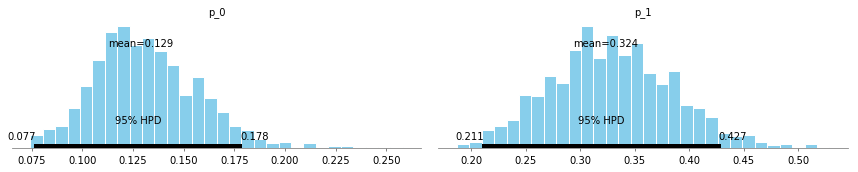

In [10]:
from pymc3 import plot_posterior

plot_posterior(ivh_trace[100:], varnames=['p'], color='#87ceeb')

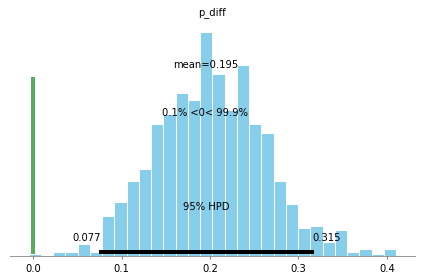

In [11]:
plot_posterior(ivh_trace[100:], varnames=['p_diff'], ref_val=0, color='#87ceeb')